In [46]:
import os
os.environ["WEBBPSF_PATH"] = 'webbpsf-data'
os.environ["WEBBPSF_EXT_PATH"] = 'webbpsf-data'
os.environ["PYSYN_CDBS"] = "cdbs"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='False'
import sys
sys.path.append('/home/blewis/GRaTeR-JAX')

from utils.objective_functions import jax_model, objective_model, objective_fit, log_likelihood, Parameter_Index,residuals
from utils.SLD_utils import DoubleHenyeyGreenstein_SPF, InterpolatedUnivariateSpline_SPF, EMP_PSF, DustEllipticalDistribution2PowerLaws, Winnie_PSF
from utils.SLD_ojax import ScatteredLightDisk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)
from astropy.io import fits
import pandas as pd
from statistical_analysis.optimize_framework import OptimizeUtils, Optimizer


Step 1: Import a GPI image as your target disk.

In [47]:
image_data = pd.read_csv('../GPI_data/image_info_filt.csv')
image_data.set_index("Name", inplace=True)
image_data.columns = ["Radius", "Inclination", "Position Angle", "Distance", "Knots"]
print(image_data)

                Radius  Inclination  Position Angle  Distance  Knots
Name                                                                
hd145560_H_pol    85.3         43.9           221.5    120.44    7.0
hd146897_H_pol    85.0         84.0           293.9    131.50    9.0
ceant_H_pol       29.8         13.1           271.0     34.03    7.0
hd111520_H_pol    81.0         88.0           165.0    108.94    7.0
hd115600_H_pol    46.0         80.0            27.5    109.62    7.0
hd129590_H_pol    66.9         75.7           121.7    136.04    9.0
hd117214_H_pol    60.2         71.0           359.8    107.61   11.0
hd35841_H_pol     60.3         84.9           345.8    103.68    7.0
hd30447_H_pol     83.0         83.0            32.3     80.54    7.0
hd32297_H_pol     98.4         88.4            47.9    132.79   13.0
hd110058_H_pol    39.0         84.0           335.0    129.98    5.0
hd111161_H_pol    72.4         62.1           263.2    109.43    7.0
hd157587_H_pol    79.0         70.

Filename: ../GPI_data/hd117214_H_pol.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     496   ()      
  1  SCI           1 ImageHDU       138   (281, 281, 4)   float32   
  2  DQ            3 ImageHDU        64   (281, 281, 2)   uint8   


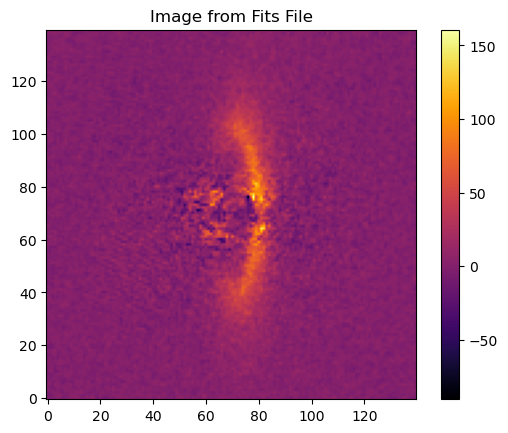

In [48]:
name = "hd117214_H_pol"
fits_image_filepath = "../GPI_data/" + str(name) + ".fits"
hdul = fits.open(fits_image_filepath)
row = image_data.loc[name]

#Displays File Info
hdul.info()

# Gets Image
target_image = OptimizeUtils.process_image(hdul['SCI'].data[1,:,:])

# Displays Image
plt.imshow(target_image, origin='lower', cmap='inferno')
plt.title("Image from Fits File")
plt.colorbar()

Now to try the optimization!

In [49]:
spf_params = InterpolatedUnivariateSpline_SPF.params
psf_params = EMP_PSF.params
spf_params['knot_values'] = [1,.6,.4,.3,.2,.1]
spf_params['num_knots'] = 6

disk_params = Parameter_Index.disk_params
disk_params['sma'] = row["Radius"]
disk_params['inclination'] = row["Inclination"]
disk_params['position_angle'] = row["Position Angle"]

misc_params = Parameter_Index.misc_params
misc_params['distance'] = row["Distance"]
#misc_params['flux_scaling'] = 5e3

img = objective_model(disk_params, spf_params, psf_params, misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)

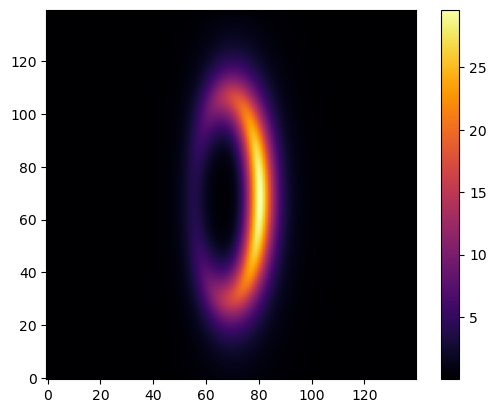

In [50]:
plt.imshow(img, origin='lower', cmap='inferno')
plt.colorbar()
plt.show()

Log-Likelihood: -52026.64001452
10000000000.0


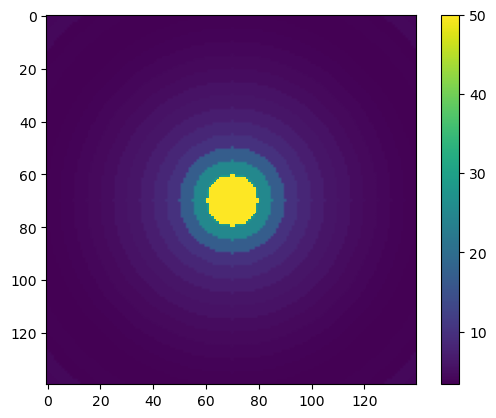

In [51]:
err_map = OptimizeUtils.process_image(OptimizeUtils.create_empirical_err_map(hdul['SCI'].data[2,:,:])) #, outlier_pixels=[(57, 68)]))
plt.imshow(err_map,vmax=50)
plt.colorbar()
print(f'Log-Likelihood: {log_likelihood(img, target_image, err_map)}')
print(np.max(err_map))

In [52]:
from scipy.optimize import minimize
jax.config.update("jax_debug_nans", True)

In [71]:
fit_keys = ['alpha_in', 'alpha_out', 'sma', 'e', 'ksi0','gamma','beta','omega','inclination', 'position_angle', 'x_center', 'y_center', 'flux_scaling','knot_values']

llp = lambda x: -objective_fit([x[0], x[1], x[2], x[3], x[4],x[5],x[6],x[7],x[8],x[9],x[10],x[11],x[12],x[13:]], fit_keys, disk_params, spf_params, psf_params, misc_params,
                              ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF, target_image,
                              err_map)

start_disk_params = disk_params
start_disk_params['sma'] = disk_params['sma']
start_disk_params['inclination'] = disk_params['inclination']
start_disk_params['position_angle'] = disk_params['position_angle']

init_x = jnp.concatenate([jnp.array([5,-5,start_disk_params['sma'], 0, 3, 2, 1, 0, start_disk_params['inclination'], start_disk_params['position_angle'],70,70,5e3]), np.asarray([.5,.5,.5,.5,.5,.5])])
print(init_x)

[ 5.00000000e+00 -5.00000000e+00  5.65038131e+01  0.00000000e+00
  3.00000000e+00  2.00000000e+00  1.00000000e+00  0.00000000e+00
  7.08424275e+01  3.58905872e+02  7.00000000e+01  7.00000000e+01
  5.00000000e+03  5.00000000e-01  5.00000000e-01  5.00000000e-01
  5.00000000e-01  5.00000000e-01  5.00000000e-01]


In [72]:
sigma2 = jnp.power(err_map, 2)
print(np.min(jnp.log(err_map)))

1.2056471


In [73]:
from scipy.optimize import minimize
jax.config.update("jax_debug_nans", True)

soln = minimize(llp, init_x, options={'disp': True, 'max_itr': 500})

         Current function value: 46523.133417
         Iterations: 30
         Function evaluations: 2009
         Gradient evaluations: 100


In [74]:
print(soln.x)

[ 9.42375377e+00 -1.05884501e-02  4.68648282e+01 -4.04414085e-03
  2.10179474e+00  1.78059716e+00 -1.75365165e+00  3.92199651e-01
  7.49151036e+01  3.57951211e+02  7.24878802e+01  7.21444116e+01
  5.00000000e+03  1.88488801e+00  1.34186272e+00  8.83560104e-01
  7.11900321e-01  3.67877165e-01  2.55289822e-01]


Log-Likelihood: -46523.13341703781


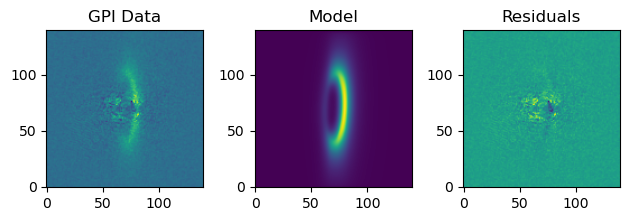

In [75]:
for k in range(len(fit_keys)):
    if k==len(fit_keys)-1:
        spf_params[fit_keys[k]] = np.abs(soln.x[k:])
    else:
        disk_params[fit_keys[k]] = soln.x[k]

best_fit_disk = objective_model(disk_params, spf_params, psf_params, misc_params,
                        ScatteredLightDisk, DustEllipticalDistribution2PowerLaws, InterpolatedUnivariateSpline_SPF, EMP_PSF)

fig, ax = plt.subplots(1,3)
ax[0].imshow(target_image,origin='lower')
ax[1].imshow(best_fit_disk,origin='lower')
ax[2].imshow(target_image-best_fit_disk,origin='lower')
ax[0].set_title('GPI Data')
ax[1].set_title('Model')
ax[2].set_title('Residuals')
plt.tight_layout()

print(f'Log-Likelihood: {log_likelihood(best_fit_disk, target_image, err_map)}')

Text(0.5, 1.0, 'hd117214_H_pol Phase Function')

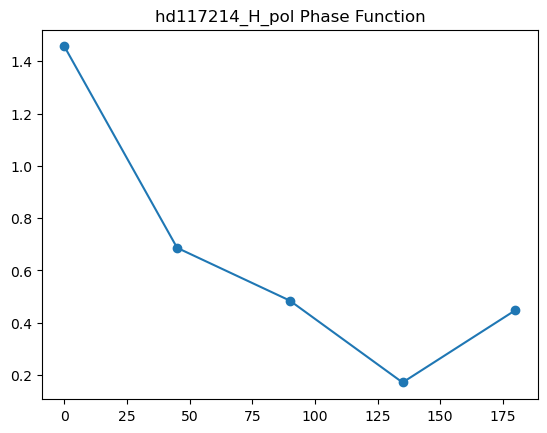

In [67]:
plt.scatter(np.linspace(0,180,len(soln.x[4:])),soln.x[4:])
plt.plot(np.linspace(0,180,len(soln.x[4:])),soln.x[4:])
plt.title('{} Phase Function'.format(name))